In [80]:
import sys
sys.path.insert(1, '../../')
from utils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, sosfiltfilt, find_peaks

def break_correct(data):
    corrected_data = np.copy(data)
    for i in range(1, len(data)):
        diff = data[i] - data[i - 1]
        if diff < -180:  # Assuming a break from 360 to 0
            corrected_data[i:] += 360
        elif diff > 180:  # Assuming a break from 0 to 360
            corrected_data[i:] -= 360
    return corrected_data

def signal_filter(data, fc1, fc2, fs, order=3):
    sos = butter(order, fc1, btype='high', fs=fs, analog=False, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    sos = butter(order, fc2, btype='low', fs=fs, analog=False, output='sos')
    filtered_data = sosfiltfilt(sos, filtered_data)
    return filtered_data

In [81]:
file_path = '../../dataset/basketball/test-2024-01-10-16-01-28.csv'
data = pd.read_csv(file_path).to_numpy()
timestamps = (data[:, 0] - data[0, 0])/ 1000
timestamps = np.linspace(0, timestamps[-1], len(timestamps))
c = data[:, 1]
b = data[:, 2]
tl = data[:, 3]
tr = data[:, 4]
r = data[:, 5]
p = data[:, 6]
y = data[:, 7]

y = break_correct(y)

In [82]:
_, c = upsample(timestamps, c, 100)
_, b = upsample(timestamps, b, 100)
_, tl = upsample(timestamps, tl, 100)
_, tr = upsample(timestamps, tr, 100)
_, y = upsample(timestamps, y, 100)
_, p = upsample(timestamps, p, 100)
_, r = upsample(timestamps, r, 100)
timestamps, _ = upsample(timestamps, timestamps, 100)

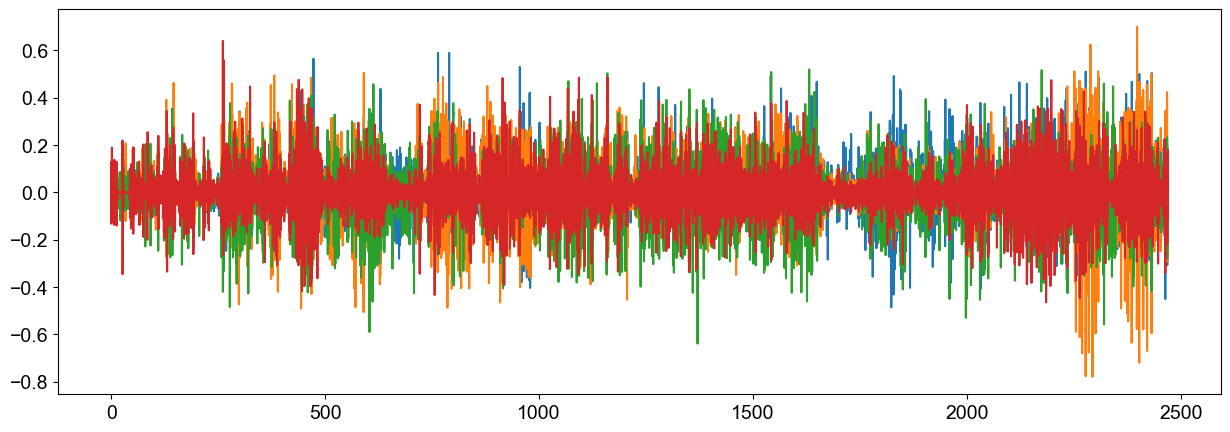

In [83]:
c = signal_filter(c, 0.4, 8, 1000)
b = signal_filter(b, 0.4, 8, 1000)
tl = signal_filter(tl, 0.4, 8, 1000)
tr = signal_filter(tr, 0.4, 8, 1000)

plt.figure(figsize=(15, 5))
plt.plot(timestamps, c)
plt.plot(timestamps, b)
plt.plot(timestamps, tl)
plt.plot(timestamps, tr)

# plt.xlim(480, 510)
plt.show()

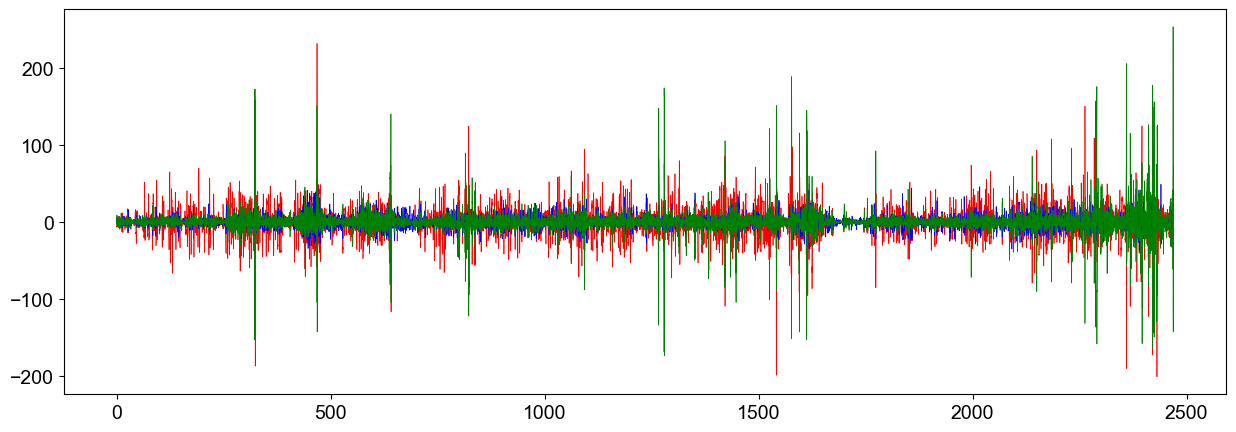

In [84]:
# Highpass filter to remove drift (assuming sampling rate of 100 Hz, and cutoff frequency of 0.1 Hz)
fs = 1000
fc1 = 0.2
fc2 = 50
y = signal_filter(y, fc1, fc2, fs)
p = signal_filter(p, fc1, fc2, fs)
r = signal_filter(r, fc1, fc2, fs)

plt.figure(figsize=(15, 5))
# plt.plot(timestamps, y, 'k--', lw=0.5)
# plt.plot(timestamps, p, 'b--', lw=0.5)
# plt.plot(timestamps, r, 'g--', lw=0.5)
plt.plot(timestamps, y, 'r', lw=0.5)
plt.plot(timestamps, p, 'b', lw=0.5)
plt.plot(timestamps, r, 'g', lw=0.5)


# plt.xlim(264, 300)

(560.0, 600.0)

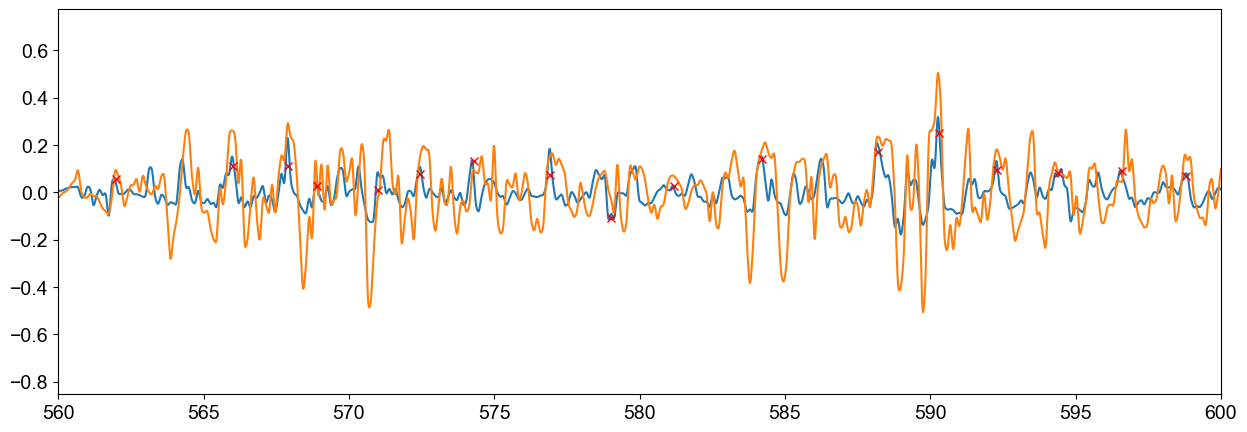

In [85]:
plt.figure(figsize=(15, 5))

events = pd.read_csv('../videos/basketball/data_points.csv', header=None).to_numpy().squeeze()
plt.plot(timestamps, c)
plt.plot(timestamps, b)
for event in events:
    plt.plot(event, c[np.where(np.abs(timestamps - event) <= 8e-2)[0][0]], 'rx')

plt.xlim(560, 600)

(600.0, 620.0)

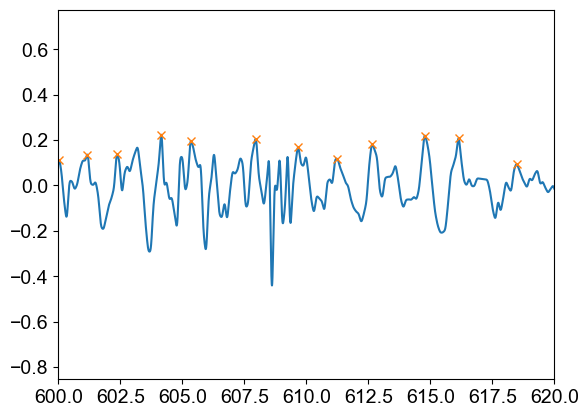

In [86]:
peaks, _ = find_peaks(b, distance=1000, height=0)

modified_events = []

for event in events:
    differences = np.abs(peaks - event * 1000)
    min_diff_index = np.argmin(differences)
    if differences[min_diff_index] <= 1000:
        modified_events.append(peaks[min_diff_index])

modified_events = np.array(modified_events)
plt.plot(timestamps, b)
plt.plot(timestamps[peaks], b[peaks], 'x')
plt.xlim(600, 620)

(600.0, 620.0)

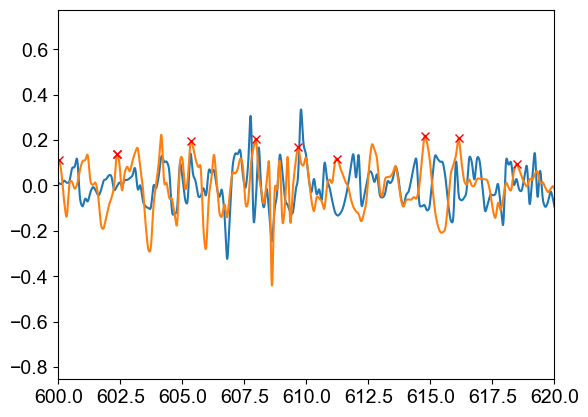

In [87]:
plt.plot(timestamps, c)
plt.plot(timestamps, b)
for event in modified_events:
    plt.plot(timestamps[event], b[event], 'rx')

plt.xlim(600, 620)

In [88]:
data1 = np.column_stack((c, b, tl, tr, y, p, r))
data1.shape

(2328701, 7)

In [89]:
# time period for each activity, [start_idx, end_idx]
jogging = [580000, 670000]
resting = [670000, 780000]
shooting = [780000, 1184000]
layup = [1184000, 1560000]

In [90]:
timestamps1 = timestamps * 0.001 / (timestamps[1] - timestamps[0])
events1 = modified_events * 0.001 / (timestamps[1] - timestamps[0])

In [91]:
def manual_find_peaks(activity, signal, height=None, distance=None):
    section_signal = signal[activity[0]:activity[1]]
    section_timestamps = timestamps1[activity[0]:activity[1]]
    idx, _ = find_peaks(section_signal, height=height, distance=distance)
    plt.plot(section_timestamps, section_signal)
    plt.plot(section_timestamps[idx], section_signal[idx], marker="o", ls="", ms=3)
    return section_timestamps[idx], idx

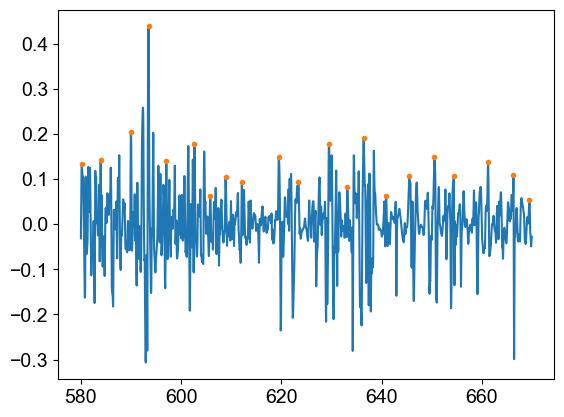

In [92]:
jogging_peak_time, jogging_peak = manual_find_peaks(jogging, c, height=0.05, distance=3000)

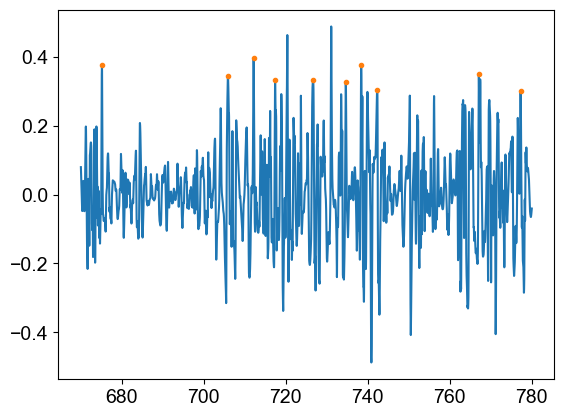

In [93]:
resting_peak_time, resting_peak = manual_find_peaks(resting, b, height=(0.3, 0.4), distance=1000)

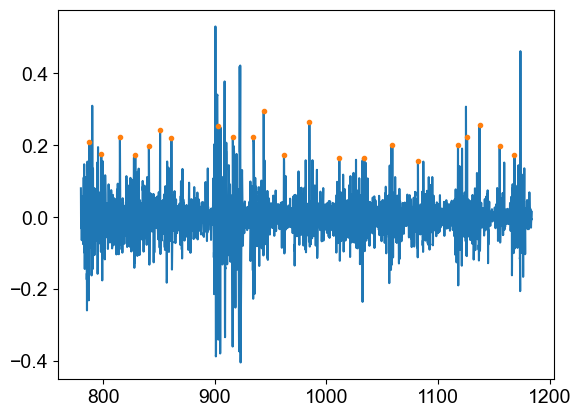

In [94]:
shooting_peak_time, shooting_peak = manual_find_peaks(shooting, c, height=(0.15, 0.3), distance=8000)

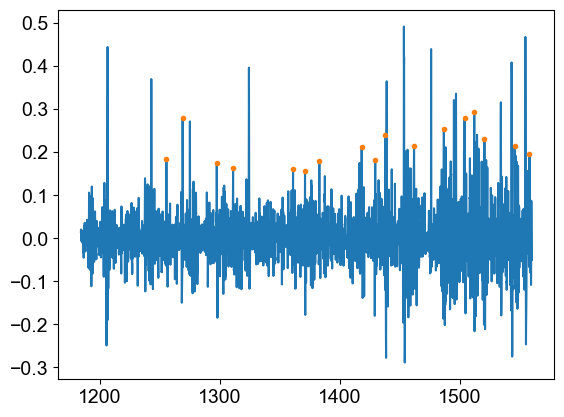

In [95]:
layup_peak_time, layup_peak = manual_find_peaks(layup, c, height=(0.15, 0.3), distance=8000)

In [96]:
window_width = 3000

num_events = len(modified_events)
temp_container = np.zeros((num_events, window_width))

for idx, event in enumerate(modified_events):
    start = event - window_width // 2
    end = event + window_width // 2
    temp_container[idx, :] = b[start:end]

avg = np.mean(temp_container, axis=0)
std = np.std(temp_container, axis=0)

mask = np.ones(len(temp_container), dtype=bool)

for idx, sample in enumerate(temp_container):
    if np.any(sample > avg + 2*std) or np.any(sample < avg - 2*std):
        mask[idx] = False

modified_events = modified_events[mask]
cough_peak_time = (modified_events / 1000).squeeze()
print(cough_peak_time.shape)

(30,)


In [112]:
peak_time = np.concatenate([cough_peak_time,
                            jogging_peak_time,
                            resting_peak_time + 2,
                            shooting_peak_time,
                            layup_peak_time])[:, np.newaxis]
peak_time.shape

(100, 1)

In [199]:
# cough 1, resting 0, jogging/shooting/layup 2
peak_activities = np.array(([1] * cough_peak_time.size) + \
                           ([0] * jogging_peak_time.size) + \
                           ([0] * resting_peak_time.size) + \
                           ([0] * shooting_peak_time.size) + \
                           ([0] * layup_peak_time.size))[:, np.newaxis]
peak_activities.shape

(100, 1)

In [200]:
peak_time_activities = np.concatenate([peak_time, peak_activities], axis=1)
peak_time_activities.shape

(100, 2)

In [201]:
peak_time_activities[peak_time_activities[:, 1] == 1][:, 0]

array([273.836, 275.317, 288.69 , 289.78 , 291.529, 306.396, 313.929,
       315.122, 318.416, 320.264, 322.681, 325.94 , 328.807, 452.643,
       457.381, 464.085, 466.318, 472.835, 565.859, 583.254, 595.637,
       599.134, 601.656, 604.595, 605.759, 607.656, 617.211, 620.461,
       623.152, 637.556])

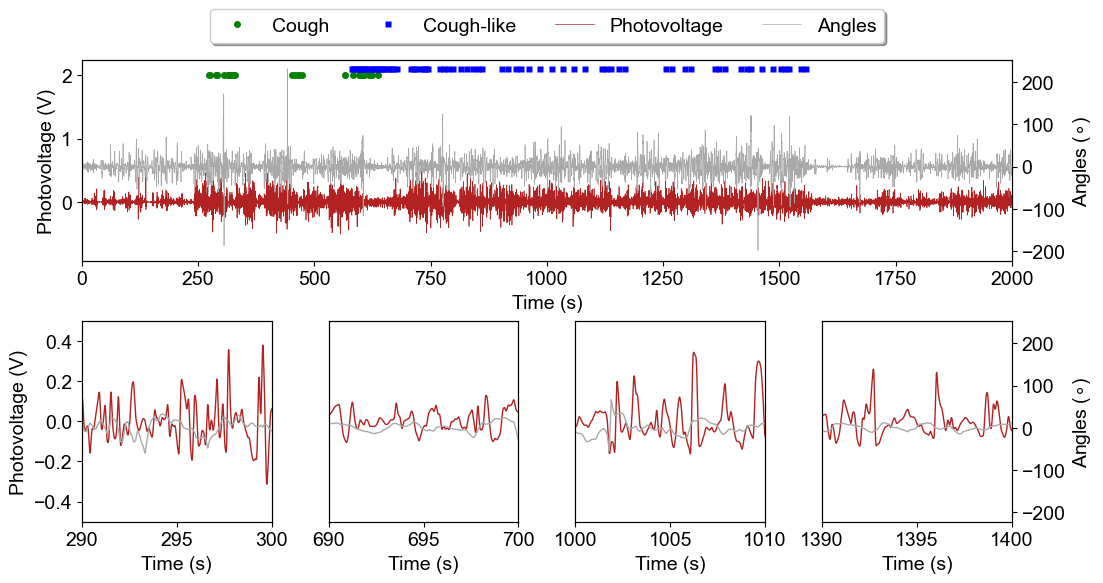

In [255]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(211)
plt.plot(peak_time_activities[peak_time_activities[:, 1] == 1][:, 0],
         2 * np.ones_like(peak_time_activities[peak_time_activities[:, 1] == 1][:, 0]),
         'o', mfc='g', mec='None', ms=5, label='Cough')
plt.plot(peak_time_activities[peak_time_activities[:, 1] != 1][:, 0],
         2.1 * np.ones_like(peak_time_activities[peak_time_activities[:, 1] != 1][:, 0]),
         's', mfc='b', mec='None', ms=5, label='Cough-like')
plt.plot(timestamps1, b, c='firebrick', lw=0.5, label='Photovoltage')
plt.xlim([0, 2000])
plt.xlabel('Time (s)')
plt.ylabel('Photovoltage (V)')
handles1, labels1 = ax.get_legend_handles_labels()
ax = ax.twinx()
plt.plot(timestamps1, y, c='darkgray', lw=0.5, label='Angles')
plt.ylabel('Angles ($\circ$)')

handles2, labels2 = ax.get_legend_handles_labels()

handles = handles1 + handles2
labels = labels1 + labels2

plt.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.3), ncols=4, fancybox=True, shadow=True)

ax = fig.add_subplot(245)
plt.plot(timestamps1, b, c='firebrick', lw=1)
plt.ylabel('Photovoltage (V)')
plt.ylim([-0.5, 0.5])
plt.xlabel('Time (s)')
ax = ax.twinx()
plt.yticks([])
plt.plot(timestamps1, y, c='darkgray', lw=1)
plt.xlim(290, 300)

ax = fig.add_subplot(246)
plt.yticks([])
plt.plot(timestamps1, b, c='firebrick', lw=1)
plt.ylim([-0.5, 0.5])
plt.xlabel('Time (s)')
ax = ax.twinx()
plt.yticks([])
plt.plot(timestamps1, y, c='darkgray', lw=1)
plt.xlim(690, 700)

ax = fig.add_subplot(247)
plt.yticks([])
plt.plot(timestamps1, b, c='firebrick', lw=1)
plt.ylim([-0.5, 0.5])
plt.xlabel('Time (s)')
ax = ax.twinx()
plt.yticks([])
plt.plot(timestamps1, y, c='darkgray', lw=1)
plt.xlim(1000, 1010)

ax = fig.add_subplot(248)
plt.yticks([])
plt.plot(timestamps1, b, c='firebrick', lw=1)
plt.ylim([-0.5, 0.5])
plt.xlabel('Time (s)')
ax = ax.twinx()
plt.ylabel('Angles ($\circ$)')
plt.plot(timestamps1, y, c='darkgray', lw=1)
plt.xlim(1390, 1400)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig('basketball_long_test.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(peak_time_activities[peak_time_activities[:, 1] == 1][:, 0],
         2 * np.ones_like(peak_time_activities[peak_time_activities[:, 1] == 1][:, 0]),
         'o', mfc='g', mec='None', ms=5, label='Cough')
plt.plot(peak_time_activities[peak_time_activities[:, 1] != 1][:, 0],
         2.1 * np.ones_like(peak_time_activities[peak_time_activities[:, 1] != 1][:, 0]),
         's', mfc='b', mec='None', ms=5, label='Cough-like')

In [203]:
window_width = 3000
expanded_peaks = peak_expand((peak_time*1000).squeeze().astype(int) - 1, window_width, len(timestamps1))

slices = []
for idx in range(expanded_peaks.shape[0]):
    if peak_time_activities[idx, 1] == 1:
        sample = data1[expanded_peaks[idx, :]]
        sample *= 5
        slices.append(sample)
    else:
        slices.append(data1[expanded_peaks[idx, :]])
slices = np.array(slices)

slices.shape

(100, 3000, 7)

In [204]:
sample.shape

(3000, 7)

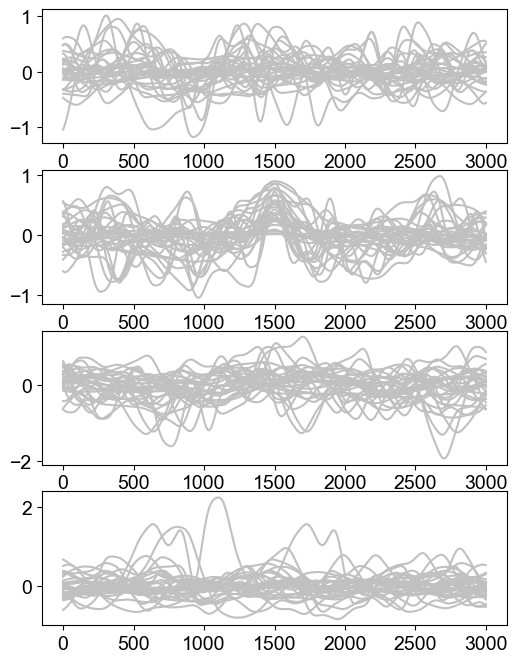

In [205]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(6, 8))

for idx, slice in enumerate(slices):
    if peak_activities[idx] == 1:
        for ch, ax in enumerate(axes):
            ax.plot(slice[:, ch], c='silver')

In [206]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torch.__config__.show())
print(f'PyTorch is running on {device}')

2.1.1
PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90
  - CuDNN 8.8.1  (built against CUDA 12.0)
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.1, CUDNN_VERSION=8.8.1, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /bigobj /FS -DUSE_PTHREADPOOL -DNDEBUG 

In [207]:
class BaseLHMDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

class LHMDualDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        photovoltage_data = self.features[idx, :4, :].float().transpose(0, 1)  # First 4 channels
        euler_angle_data = self.features[idx, 4:, :].float().transpose(0, 1)  # Last 3 channels
        return photovoltage_data, euler_angle_data, self.labels[idx]
    
features = torch.tensor(slices).permute(0, 2, 1).type(torch.LongTensor)
labels = peak_time_activities[:, 1]
labels = torch.tensor(labels).type(torch.LongTensor)

print(features.shape)
print(labels.shape)

dual_ds = LHMDualDataset(features, labels)
dual_ds.features.shape

torch.Size([100, 7, 3000])
torch.Size([100])


torch.Size([100, 7, 3000])

In [208]:
input_dim1 = 4 # For photovoltage data
input_dim2 = 3 # For Euler angle data
hidden_dim = 128
layer_dim = 1
output_dim = len(np.unique(peak_activities.ravel())) # Number of classes
dropout_prob = 0

num_epochs = 100

# Preparing data
batch_size = 32

total_samples = len(dual_ds)
test_size = int(0.2 * total_samples)
train_size = total_samples - test_size

train_dataset_dual, test_dataset_dual = random_split(dual_ds, [train_size, test_size])
train_loader_dual = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=False)
test_loader_dual = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)

In [209]:
class DualGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        out1, _ = self.gru1(x1)
        out2, _ = self.gru2(x2)

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

In [210]:
# Container for losses and accuracies
train_losses_gru_dual = []
train_accuracies_gru_dual = []

test_losses_gru_dual = []
test_accuracies_gru_dual = []

# Model definition
model_gru_dual = DualGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
criterion = nn.CrossEntropyLoss()
optimizer_dual = torch.optim.Adam(model_gru_dual.parameters(), lr=0.0001, weight_decay=0.001)
print(model_gru_dual.to(device))

for epoch in range(num_epochs):
    model_gru_dual.train()  # Set the model to training mode
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    temp_out_pack = torch.zeros((1, model_gru_dual.output_dim)).to(device)

    for photovoltage_data, euler_angle_data, labels in train_loader_dual:
        # Load data
        photovoltage_data = photovoltage_data.to(device)
        euler_angle_data = euler_angle_data.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_gru_dual(photovoltage_data, euler_angle_data)
        temp_out_pack = torch.vstack((temp_out_pack, outputs))
        loss = criterion(outputs, labels.squeeze())

        # Backward pass and optimization
        optimizer_dual.zero_grad()
        loss.backward()
        optimizer_dual.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader_dual)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_gru_dual.append(avg_train_loss)
    train_accuracies_gru_dual.append(train_accuracy)

    model_gru_dual.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for photovoltage_data, euler_angle_data, labels in test_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device).float()
            euler_angle_data = euler_angle_data.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_dual(photovoltage_data, euler_angle_data)
            temp_out_pack = torch.vstack((temp_out_pack, outputs))
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

    avg_test_loss = total_test_loss / len(test_loader_dual)
    test_accuracy = total_test_correct / total_test_samples
    test_losses_gru_dual.append(avg_test_loss)
    test_accuracies_gru_dual.append(test_accuracy)

    # Print training and testing statistics for each epoch
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


DualGRUModel(
  (gru1): GRU(4, 128, batch_first=True)
  (gru2): GRU(3, 128, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/100], Train Loss: 0.6375, Train Accuracy: 0.6000, Test Loss: 0.7421, Test Accuracy: 0.5000
Epoch [10/100], Train Loss: 0.6054, Train Accuracy: 0.6625, Test Loss: 0.7017, Test Accuracy: 0.5500
Epoch [15/100], Train Loss: 0.5776, Train Accuracy: 0.6875, Test Loss: 0.6640, Test Accuracy: 0.6500
Epoch [20/100], Train Loss: 0.5525, Train Accuracy: 0.7375, Test Loss: 0.6276, Test Accuracy: 0.7500
Epoch [25/100], Train Loss: 0.5295, Train Accuracy: 0.7750, Test Loss: 0.5921, Test Accuracy: 0.8500
Epoch [30/100], Train Loss: 0.5089, Train Accuracy: 0.8000, Test Loss: 0.5585, Test Accuracy: 0.8500
Epoch [35/100], Train Loss: 0.4913, Train Accuracy: 0.8125, Test Loss: 0.5313, Test Accuracy: 0.9000
Epoch [40/100], Train Loss: 0.4758, Train Accuracy: 0.8250, Test Loss: 0.5155, Test Accuracy: 0.9000
Epoch [

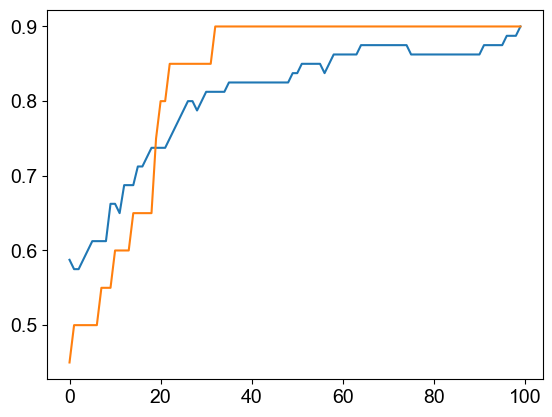

In [211]:
plt.plot(train_accuracies_gru_dual)
plt.plot(test_accuracies_gru_dual)

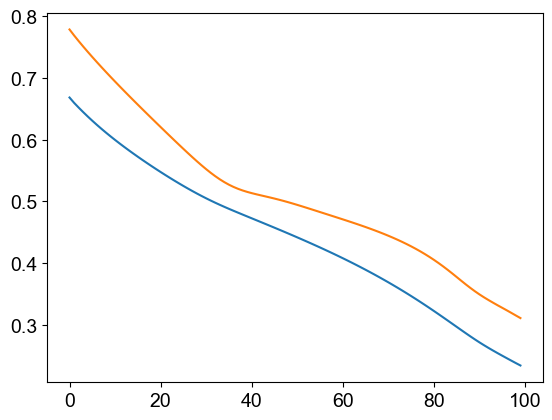

In [212]:
plt.plot(train_losses_gru_dual)
plt.plot(test_losses_gru_dual)

In [213]:
probabilities = torch.exp(temp_out_pack[1:, :]).cpu()
probabilities

tensor([[0.1684, 0.8316],
        [0.1675, 0.8325],
        [0.1613, 0.8387],
        [0.9266, 0.0734],
        [0.9795, 0.0205],
        [0.8996, 0.1004],
        [0.8329, 0.1671],
        [0.2315, 0.7685],
        [0.7352, 0.2648],
        [0.4715, 0.5285],
        [0.9304, 0.0696],
        [0.9573, 0.0427],
        [0.5997, 0.4003],
        [0.9741, 0.0259],
        [0.1149, 0.8851],
        [0.8356, 0.1644],
        [0.8374, 0.1626],
        [0.9855, 0.0145],
        [0.5302, 0.4698],
        [0.9810, 0.0190],
        [0.8367, 0.1633],
        [0.6171, 0.3829],
        [0.9832, 0.0168],
        [0.9701, 0.0299],
        [0.7448, 0.2552],
        [0.7321, 0.2679],
        [0.6457, 0.3543],
        [0.7833, 0.2167],
        [0.6378, 0.3622],
        [0.9851, 0.0149],
        [0.9660, 0.0340],
        [0.5599, 0.4401],
        [0.9807, 0.0193],
        [0.2772, 0.7228],
        [0.6083, 0.3917],
        [0.9796, 0.0204],
        [0.9703, 0.0297],
        [0.8984, 0.1016],
        [0.8

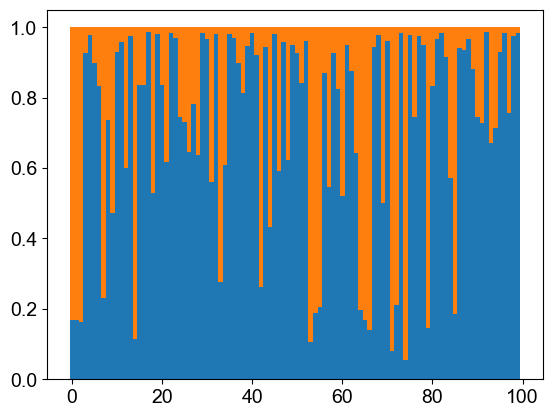

In [215]:
# rest_amplitude = temp_out_pack[1:, 0]
# cough_amplitude = temp_out_pack[1:, 1]
# exercise_amplitude = temp_out_pack[1:, 2]

x = torch.arange(len(probabilities))
bottom = torch.zeros_like(x).float()

fig, ax = plt.subplots()
for idx in range(model_gru_dual.output_dim):
    ax.bar(x, probabilities[:, idx], 1, bottom=bottom)
    bottom += probabilities[:, idx]